# Resistive Wall Wakefields

This module provides analytical models for **short-range resistive wall wakefields** in accelerator beam pipes, based on the approach described in SLAC-PUB-10707.

## Physics Background

When a relativistic charged particle travels through a conducting beam pipe, it induces image currents in the pipe walls. Due to the finite conductivity of the wall material, these currents penetrate into the conductor and dissipate energy, creating a **wakefield** that acts on trailing particles.

At high frequencies (short distances), the AC conductivity of metals deviates from DC behavior due to the Drude relaxation time $\tau$:

$$\sigma(\omega) = \frac{\sigma_0}{1 - i\omega\tau}$$

This frequency dependence causes the wakefield to oscillate and decay exponentially behind the source particle.

### Characteristic Scales

- **$s_0$**: Characteristic length scale where the wake transitions from the $1/\sqrt{z}$ DC behavior to oscillatory AC behavior:
  $$s_0 = \left( \frac{2a^2}{Z_0 \sigma_0} \right)^{1/3}$$

- **$W_0$**: Characteristic wake amplitude: $W_0 = c Z_0 / (\pi a^2)$ (round geometry)

## Classes

| Class | Description | Speed | Accuracy |
|-------|-------------|-------|----------|
| `ResistiveWallWakefield` | Full impedance model using FFT convolution | Slower | High |
| `ResistiveWallPseudomode` | Damped sinusoid approximation | Fast (O(N)) | ~10-20% error |

## Key Methods

| Method | Description |
|--------|-------------|
| `wake(z)` | Evaluate wakefield $W(z)$ at position(s) $z$ [V/C/m] |
| `impedance(k)` | Evaluate impedance $Z(k)$ at wavenumber(s) $k$ [Ω/m] |
| `convolve_density(ρ, dz, plot=False)` | Compute integrated wake from charge density |
| `particle_kicks(z, weight)` | Compute per-particle momentum kicks [eV/m] |
| `plot()` | Visualize the wakefield |

Use `ParticleGroup.apply_wakefield(wake, length)` to apply wakefield kicks to particles.

## Sign Convention

- $z < 0$: Behind the source (trailing particle feels the wake)
- $z > 0$: Ahead of the source (causality requires $W = 0$)
- Positive $W(z)$ corresponds to energy **loss** (decelerating field)
- Tail particles lose more energy than head particles

---
## Quick Start

Create a wakefield, evaluate it, and apply it to particles in just a few lines:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.wakefields import ResistiveWallWakefield, ResistiveWallPseudomode
from pmd_beamphysics.units import epsilon_0

# Create wakefield from material preset
wake = ResistiveWallWakefield.from_material(
    "copper-slac-pub-10707",
    radius=2.5e-3,  # 2.5 mm pipe radius
    geometry="flat",
)
wake

ResistiveWallWakefield(radius=0.0025, conductivity=65000000.0, relaxation_time=2.7e-14, geometry='flat', material='copper-slac-pub-10707') → s₀=7.992e-06 m

### Visualize the wakefield and impedance

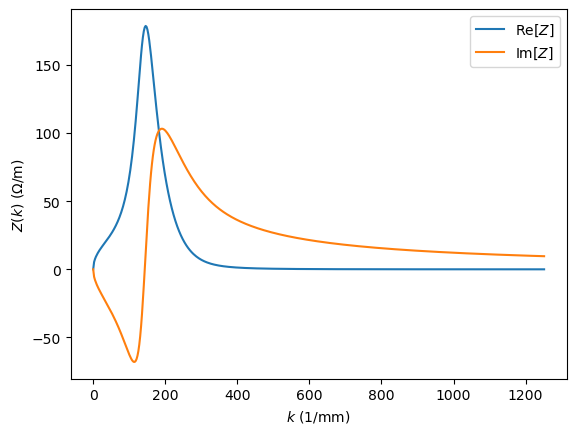

In [2]:
wake.plot_impedance()

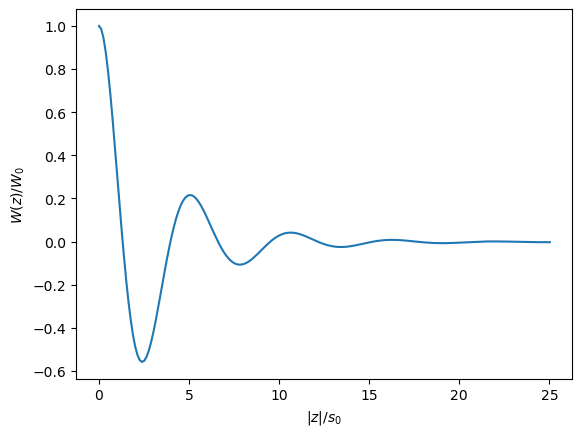

In [3]:
wake.plot(zmax=200e-6, normalized=True)

### Apply to particles

Load a particle distribution and visualize the wakefield kicks. Note: particles must be at constant time (use `drift_to_t()`) for proper wake calculation.

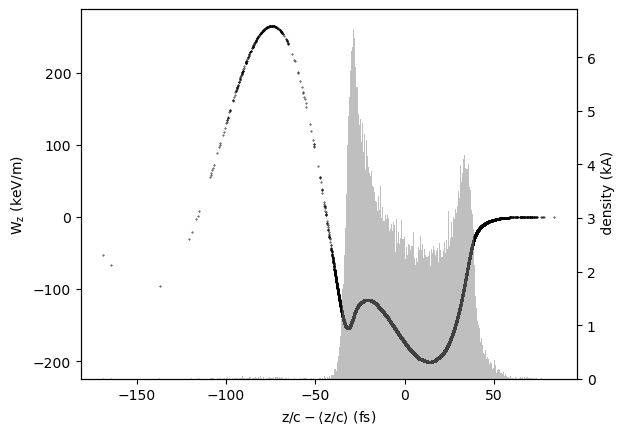

In [4]:
P = ParticleGroup("../data/bmad_particles2.h5")
P.drift_to_t()  # Align particles at constant time
P.wakefield_plot(wake)

In [5]:
# Apply wakefield over 10 m of beam pipe (returns a modified copy)
P_after = P.apply_wakefield(wake, length=10.0)

# Mean energy change [keV] - negative means energy loss
(P_after["mean_energy"] - P["mean_energy"]) / 1e3

np.float64(-1376.4140474233627)

---
## Setup

---
## Creating Wakefield Models

### Direct Construction

Specify the pipe geometry and material properties directly:

In [6]:
# Accurate impedance-based model
wake = ResistiveWallWakefield(
    radius=2.5e-3,  # Pipe radius [m] (or half-gap for flat)
    conductivity=6.5e7,  # DC conductivity σ₀ [S/m]
    relaxation_time=27e-15,  # Drude relaxation time τ [s]
    geometry="round",  # "round" or "flat"
)
wake

ResistiveWallWakefield(radius=0.0025, conductivity=65000000.0, relaxation_time=2.7e-14, geometry='round', material='copper-slac-pub-10707') → s₀=7.992e-06 m

In [7]:
# Fast pseudomode approximation
wake_fast = ResistiveWallPseudomode(
    radius=2.5e-3,
    conductivity=6.5e7,
    relaxation_time=27e-15,
    geometry="round",
)
wake_fast

ResistiveWallPseudomode(radius=0.0025, conductivity=65000000.0, relaxation_time=2.7e-14, geometry='round', material='copper-slac-pub-10707') → s₀=7.992e-06 m, Γ=1.013, k_r=199535.0/m, Q_r=3.55

### Material Presets

Common materials with known conductivity and relaxation times are available:

In [8]:
# Available materials (SI units)
ResistiveWallWakefield.MATERIALS

{'copper-slac-pub-10707': {'conductivity': 65000000.0,
  'relaxation_time': 2.7e-14},
 'copper-genesis4': {'conductivity': 58130000.0, 'relaxation_time': 2.7e-14},
 'aluminum-genesis4': {'conductivity': 35710000.0, 'relaxation_time': 8e-15},
 'aluminum-slac-pub-10707': {'conductivity': 42000000.0,
  'relaxation_time': 8e-15},
 'aluminum-alloy-6061-t6-20C': {'conductivity': 25000000.0,
  'relaxation_time': 8e-15},
 'aluminum-alloy-6063-t6-20C': {'conductivity': 30000000.0,
  'relaxation_time': 8e-15}}

In [9]:
# Create from material preset
wake_cu = ResistiveWallWakefield.from_material(
    "copper-slac-pub-10707",
    radius=4.5e-3,
    geometry="flat",
)
wake_cu

ResistiveWallWakefield(radius=0.0045, conductivity=65000000.0, relaxation_time=2.7e-14, geometry='flat', material='copper-slac-pub-10707') → s₀=1.183e-05 m

Key material properties (conductivity [S/m], relaxation time [s], characteristic length $s_0$ [m]):

In [10]:
wake_cu.conductivity, wake_cu.relaxation_time, wake_cu.s0

(65000000.0, 2.7e-14, 1.1825977087388154e-05)

---
## Evaluating the Wakefield

### Wake Function W(z)

The wakefield is defined for a trailing particle at position $z$ relative to the source:
- $z < 0$: Behind the source (trailing particle feels the wake)
- $z > 0$: Ahead of the source (causality requires $W = 0$)

In [11]:
# Evaluate at single point (10 µm behind source) [V/C/m]
wake.wake(-10e-6)

-1593077197930949.8

(-20.0, 200.0)

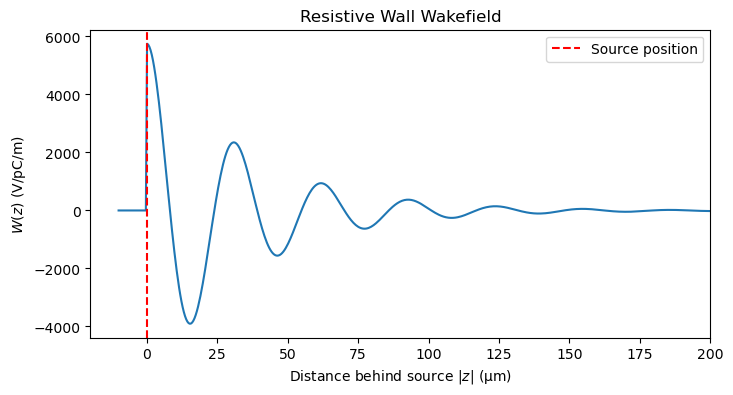

In [12]:
# Evaluate on array
z_arr = np.linspace(-200e-6, 10e-6, 500)
W_arr = wake.wake(z_arr)

plt.figure(figsize=(8, 4))
plt.plot(-z_arr * 1e6, W_arr * 1e-12)
plt.axvline(0, color="r", ls="--", label="Source position")
plt.xlabel(r"Distance behind source $|z|$ (µm)")
plt.ylabel(r"$W(z)$ (V/pC/m)")
plt.title("Resistive Wall Wakefield")
plt.legend()
plt.xlim(-20, 200)

### Impedance and Wakefield plots

The longitudinal impedance as a function of wavenumber $k$:

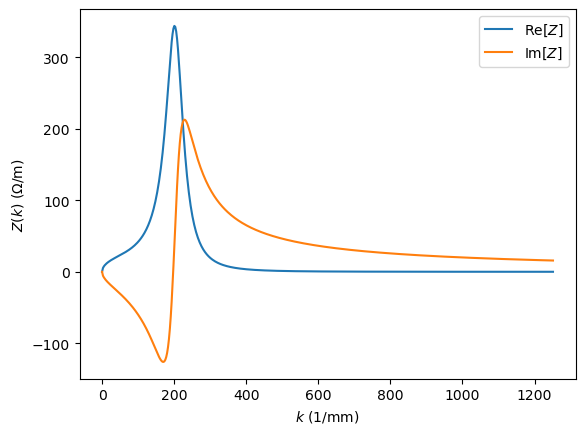

In [13]:
wake.plot_impedance()

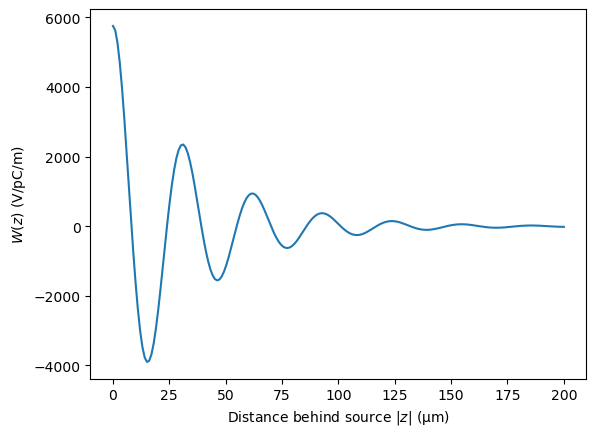

In [14]:
wake.plot(zmax=200e-6)

---
## Round vs Flat Geometry

The flat (parallel plate) geometry has a higher wake amplitude due to the different boundary conditions:

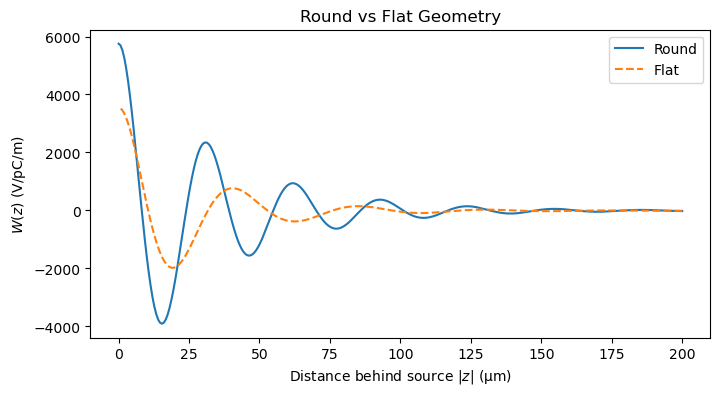

In [15]:
params = dict(radius=2.5e-3, conductivity=6.5e7, relaxation_time=27e-15)

wake_round = ResistiveWallWakefield(**params, geometry="round")
wake_flat = ResistiveWallWakefield(**params, geometry="flat")

z = np.linspace(-200e-6, 0, 300)

plt.figure(figsize=(8, 4))
plt.plot(-z * 1e6, wake_round.wake(z) * 1e-12, label="Round")
plt.plot(-z * 1e6, wake_flat.wake(z) * 1e-12, "--", label="Flat")
plt.xlabel(r"Distance behind source $|z|$ (µm)")
plt.ylabel(r"$W(z)$ (V/pC/m)")
plt.title("Round vs Flat Geometry")
plt.legend()

---
## Convolution with Charge Density

The `convolve_density` method computes the integrated wake potential from a charge density distribution:

$$V(z) = \int_{z}^{\infty} \rho(z') \, W(z - z') \, dz'$$

In [16]:
# Create a Gaussian bunch density
n_bins = 500
dz = 1e-6  # 1 µm spacing
z = np.arange(n_bins) * dz

Q_total = 100e-12  # 100 pC
sigma_z = 10e-6  # 10 µm RMS
z0 = z[n_bins // 2]  # Center

density = (
    Q_total / (sigma_z * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((z - z0) / sigma_z) ** 2)
)

# Total charge [pC]
np.sum(density) * dz * 1e12

np.float64(100.00000000000001)

array([-3.24323297e+002, -3.27984816e+002, -3.33798033e+002,
       -3.41724783e+002, -3.51633980e+002, -3.63301633e+002,
       -3.76414898e+002, -3.90580211e+002, -4.05335407e+002,
       -4.20165551e+002, -4.34522010e+002, -4.47844147e+002,
       -4.59582857e+002, -4.69225029e+002, -4.76317952e+002,
       -4.80492586e+002, -4.81484635e+002, -4.79152370e+002,
       -4.73490234e+002, -4.64637393e+002, -4.52880540e+002,
       -4.38650489e+002, -4.22512330e+002, -4.05149181e+002,
       -3.87339835e+002, -3.69930915e+002, -3.53804401e+002,
       -3.39841649e+002, -3.28885242e+002, -3.21700204e+002,
       -3.18936205e+002, -3.21092450e+002, -3.28486950e+002,
       -3.41231749e+002, -3.59215560e+002, -3.82095002e+002,
       -4.09295345e+002, -4.40021308e+002, -4.73278050e+002,
       -5.07902082e+002, -5.42601348e+002, -5.76003306e+002,
       -6.06709434e+002, -6.33354155e+002, -6.54665949e+002,
       -6.69528096e+002, -6.77036440e+002, -6.76551463e+002,
       -6.67742086e+002,

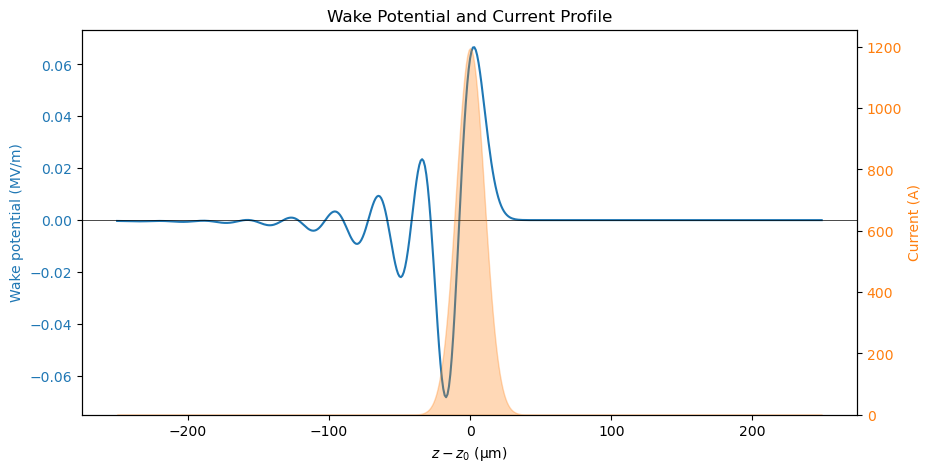

In [17]:
# Compute integrated wake with built-in plotting
wake.convolve_density(density, dz, plot=True)

---
## Particle Methods

### Computing Per-Particle Kicks

The `particle_kicks` method computes the wakefield-induced momentum change for each particle:

In [18]:
# Load particles
P = ParticleGroup("../data/bmad_particles2.h5")
P.drift_to_t()  # Align at constant time
P

<ParticleGroup with 100000 particles at 0x7f5507b4c190>

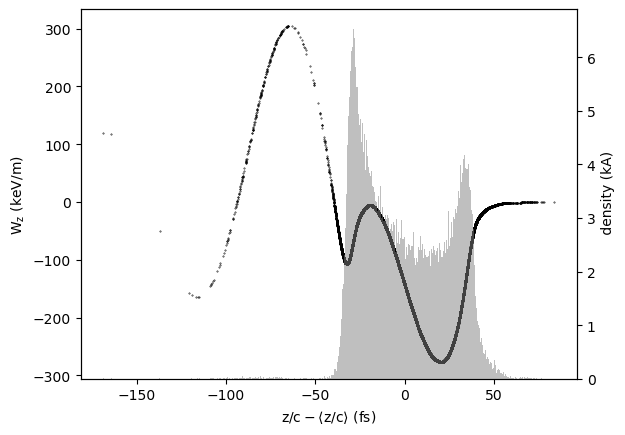

In [19]:
# Compute kicks [eV/m] and visualize
kicks = wake.particle_kicks(P.z, P.weight)
P.wakefield_plot(wake)

### Applying to Particles

Use `ParticleGroup.apply_wakefield()` to apply the kicks:

Apply wakefield over 10 m (returns a copy by default):

In [20]:
P_after = P.apply_wakefield(wake, length=10.0)

# Change in mean pz [MeV/c]
(P_after["mean_pz"] - P["mean_pz"]) * 1e-6

np.float64(-1.16122149968338)

Or modify in-place with `inplace=True`:

In [21]:
P_copy = P.copy()
P_copy.apply_wakefield(wake, length=10.0, inplace=True)

### ParticleGroup Wakefield Plot

A convenience method for visualizing the wakefield effect on a particle distribution:

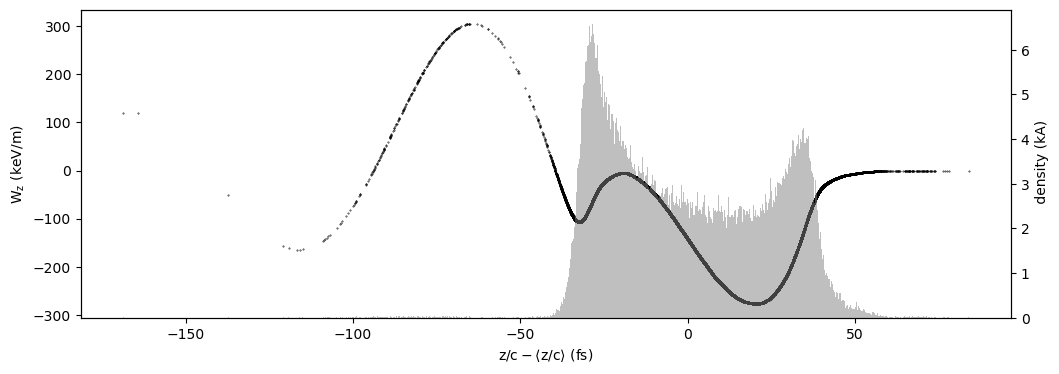

In [22]:
# Larger figure for detail
P.wakefield_plot(wake, figsize=(12, 4))

---
## Comparing Models: Accurate vs Fast

Two implementations are available with different speed/accuracy trade-offs:

- **`ResistiveWallWakefield`**: Uses FFT-based impedance integration. More accurate, especially near the first oscillation peak.
- **`ResistiveWallPseudomode`**: Uses a damped sinusoid fit from polynomial approximations. Very fast (O(N) for particle kicks), with ~10-20% error.

In [23]:
# Create both models with same parameters
params = dict(
    radius=2.5e-3,
    conductivity=6.5e7,
    relaxation_time=27e-15,
    geometry="round",
)

wake_accurate = ResistiveWallWakefield(**params)
wake_fast = ResistiveWallPseudomode(**params)

In [24]:
wake_accurate

ResistiveWallWakefield(radius=0.0025, conductivity=65000000.0, relaxation_time=2.7e-14, geometry='round', material='copper-slac-pub-10707') → s₀=7.992e-06 m

In [25]:
wake_fast

ResistiveWallPseudomode(radius=0.0025, conductivity=65000000.0, relaxation_time=2.7e-14, geometry='round', material='copper-slac-pub-10707') → s₀=7.992e-06 m, Γ=1.013, k_r=199535.0/m, Q_r=3.55

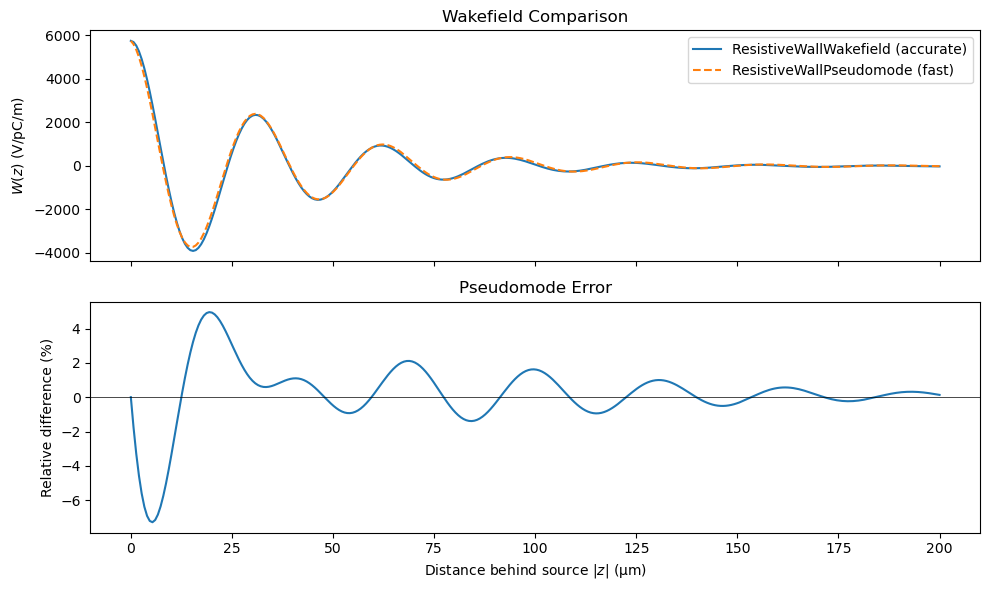

In [26]:
# Compare wake functions
z = np.linspace(-200e-6, 0, 300)

W_accurate = wake_accurate.wake(z)
W_fast = wake_fast.wake(z)

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax = axes[0]
ax.plot(-z * 1e6, W_accurate * 1e-12, label="ResistiveWallWakefield (accurate)")
ax.plot(-z * 1e6, W_fast * 1e-12, "--", label="ResistiveWallPseudomode (fast)")
ax.set_ylabel(r"$W(z)$ (V/pC/m)")
ax.legend()
ax.set_title("Wakefield Comparison")

ax = axes[1]
rel_diff = (W_fast - W_accurate) / np.abs(W_accurate).max() * 100
ax.plot(-z * 1e6, rel_diff)
ax.set_xlabel(r"Distance behind source $|z|$ (µm)")
ax.set_ylabel("Relative difference (%)")
ax.set_title("Pseudomode Error")
ax.axhline(0, color="k", lw=0.5)

plt.tight_layout()

### Performance Comparison

In [27]:
%%timeit -n 10 -r 3
# Accurate model: convolve_density
_ = wake_accurate.convolve_density(density, dz)

2.2 ms ± 78.3 μs per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [28]:
%%timeit -n 100 -r 3
# Fast model: convolve_density
_ = wake_fast.convolve_density(density, dz)

160 μs ± 6.2 μs per loop (mean ± std. dev. of 3 runs, 100 loops each)


---
## Pseudomode Properties

`ResistiveWallPseudomode` models the wakefield as a damped sinusoid:

$$W(z) = A \cdot e^{d \cdot z} \cdot \sin(k_r z + \phi)$$

The parameters are computed from polynomial fits to SLAC-PUB-10707 data:

Characteristic scales ($s_0$ [m], $\Gamma$, $k_r$ [1/m], $Q_r$):

In [29]:
wake_fast.s0, wake_fast.Gamma, wake_fast.kr, wake_fast.Qr

(7.991997937835282e-06,
 1.012812619442749,
 np.float64(199535.03396550965),
 np.float64(3.5452850664129434))

In [30]:
# Access the underlying pseudomode(s) - each has amplitude A, decay d, wavenumber k, phase phi
wake_fast.modes

[Pseudomode(A=5752033143156176.0, d=np.float64(28140.9012572571), k=np.float64(199535.03396550965), phi=1.5707963267948966)]

### Bmad Export

`ResistiveWallPseudomode` can export to Bmad format for use in external tracking codes:

In [31]:
wake_fast.to_bmad()

'! AC Resistive wall wakefield\n! Adapted from SLAC-PUB-10707\n!    Material        : copper-slac-pub-10707\n!    Conductivity    : 65000000.0 S/m\n!    Relaxation time : 2.7e-14 s\n!    Geometry        : round\n!    Radius          : 0.0025 m\n!    s₀              : 7.991997937835282e-06  m\n!    Γ               : 1.012812619442749 \n! sr_wake =  \n{z_scale=1, amp_scale=1, scale_with_length=True, z_max=100,\nlongitudinal = {5752033143156176.0, 28140.9012572571, 199535.03396550965, 0.25, none}}\n'

---
## Validation Against SLAC-PUB-10707

Compare our implementation against digitized data from the original paper:

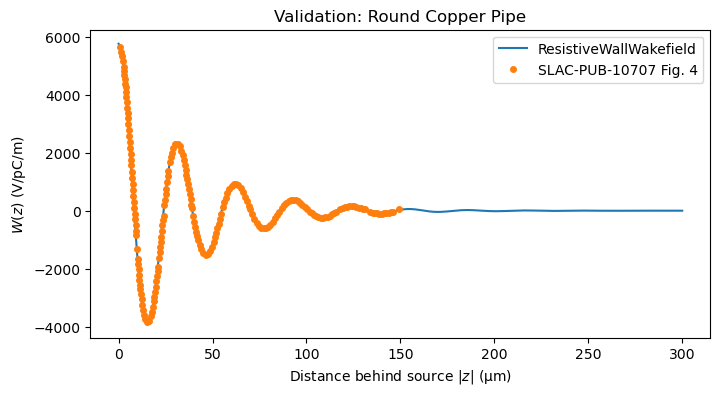

In [32]:
def validate_against_slacpub(figure_num):
    """Compare against digitized SLAC-PUB-10707 figures."""
    geometry = "round" if figure_num == 4 else "flat"
    radius = 2.5e-3

    # Load digitized data
    data = np.loadtxt(
        f"../data/SLAC-PUB-10707-digitized-Fig{figure_num}-AC-Cu.csv", delimiter=","
    )
    z_ref = data[:, 0] * 1e-6  # µm → m
    # Convert from paper's CGS units
    W_ref = data[:, 1] * 4 / radius**2 / (4 * np.pi * epsilon_0)

    # Create our model
    wake = ResistiveWallWakefield.from_material(
        "copper-slac-pub-10707",
        radius=radius,
        geometry=geometry,
    )

    z = np.linspace(0, 300e-6, 300)
    W = wake.wake(-z)

    plt.figure(figsize=(8, 4))
    plt.plot(z * 1e6, W * 1e-12, label="ResistiveWallWakefield")
    plt.plot(
        z_ref * 1e6, W_ref * 1e-12, "o", ms=4, label=f"SLAC-PUB-10707 Fig. {figure_num}"
    )
    plt.xlabel(r"Distance behind source $|z|$ (µm)")
    plt.ylabel(r"$W(z)$ (V/pC/m)")
    plt.title(f"Validation: {geometry.title()} Copper Pipe")
    plt.legend()


validate_against_slacpub(4)  # Round geometry

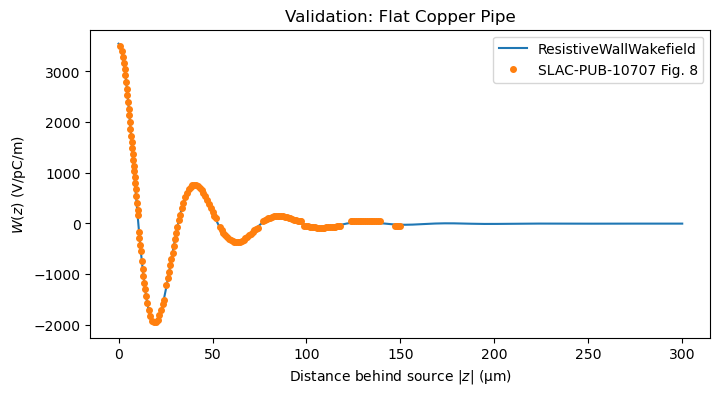

In [33]:
validate_against_slacpub(8)  # Flat geometry

---
## Summary

| Feature | `ResistiveWallWakefield` | `ResistiveWallPseudomode` |
|---------|--------------------------|---------------------------|
| Method | FFT-based impedance | Damped sinusoid fit |
| Accuracy | High | Good (~10-20% error) |
| Speed | Moderate | Very fast |
| Impedance access | ✓ | ✓ (analytical) |
| Bmad export | ✗ | ✓ |
| Best for | General use, validation | Production tracking |

Both classes share the same API:
- `wake(z)` - Evaluate wakefield
- `impedance(k)` - Evaluate impedance
- `convolve_density(density, dz, plot=False)` - Density convolution
- `particle_kicks(z, weight)` - Per-particle kicks
- `plot()` - Visualize wakefield
- `plot_impedance()` - Visualize impedance
- `from_material()` - Create from preset

Use `ParticleGroup.apply_wakefield(wake, length)` to apply kicks to particles.